Side-by-side looks at the FFIs from Kepler and TESS for targets where those match up in time!

In [134]:
from astroquery.mast import Observations, Catalogs, Tesscut
import astropy
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [120]:
# from https://iopscience.iop.org/2515-5172/2/4/192/suppdata/rnaasaae9e2t1_mrt.txt
cols = ["EPIC", "TICID", "DR2Name", "RADeg", "DEDeg"]
dfdict = {c : [] for c in cols}
charlimits = [0, 9, 19, 39, 51, 63]
with open("../data/kepler_tess_simultaneous_targets.txt") as f:
    allrows = f.read().split('\n')[27:]
    for row in allrows[:-1]:
        for i, col in enumerate(cols):
            if any([x != " " for x in row[charlimits[i]:charlimits[i+1]]]):
                target_dtype = int if i < 3 else float
                val = target_dtype(row[charlimits[i]:charlimits[i+1]])
                dfdict[col].append(val)
            else:
                dfdict[col].append(np.nan)
    
    simultaneous_targets = pd.DataFrame(data=dfdict, columns=cols).fillna(0).astype({"EPIC" : int, "TICID" : int, "DR2Name" : int, "RADeg" : float, "DEDeg" : float})

allstars = pd.read_csv("~/projects/pals/tesscomp-prototyping/data/tesstargets/tess_stellar_all.csv") # local file generated from my "tessdataproducts" module's "stellar:get_tess_stellar_catalog" method: change the path if you're running this/I'll upload the CSV somewhere
get_sectors = lambda ticid: allstars["sectors"].values[np.where(ticid == allstars["ticid"])]

In [73]:
simultaneous_targets

,EPIC,TICID,DR2Name,RADeg,DEDeg
0,245925582,4554210,2413051302797084672,347.998206,-11.933554
1,245929348,4579916,2413014469157323264,348.407601,-11.749342
2,245931711,4582469,2413392224416454656,348.516775,-11.629405
3,245927251,4520668,2413067451874115584,347.867863,-11.852871
4,245933030,4579787,2413442527073427456,348.275732,-11.566588
...,...,...,...,...,...
166,251816599,4579843,2413059171176940544,348.279026,-11.809766
167,251816601,4520629,0,347.835192,-11.809116
168,245930077,4579923,0,348.431760,-11.713218
169,251816651,0,0,349.426691,-11.090669


In [ ]:
idx = 1 # or any other number 0-170
get_dtype = lambda i: int if i < 3 else float
epic, ticid, ra, dec = (get_dtype(i)(simultaneous_targets.loc[idx][i]) for i in [0, 1, 3, 4])

# first, I'm interested in time-sync: when did TESS look at this, and when did K2 look at it?
# assume for what follows that I've got the correct sector of TESS data

def get_TPF_TESS(ID:int, ra:float, dec:float, sector:int):
    """
    Queries TIC for a target star and returns its TPF.
    Args:
        ID (int): TIC ID of the target.
        sectors (numpy array): Sectors in which the target has been observed.
    Returns:
        TPF (numpy array): Time-series FFI of the target. 
        time (numpy array): Times corresponding to each image.
    """
    
    # find coordinates of the target
    df = Catalogs.query_object("TIC"+str(ID), radius=0.0001, catalog="TIC").to_pandas()
    # get the TPF with TESScut
    cutout_coord = SkyCoord(ra, dec, unit="deg")
    cutout_hdu = Tesscut.get_cutouts(cutout_coord, size=20, sector=sector)[0]
    TPF = cutout_hdu[1].data["Flux"]
    time = cutout_hdu[1].data["Time"]
    return TPF, time

def get_TPF_K2(ID:str, ra:float, dec:float):
    """
    Queries EPIC for a target star and returns its TPF.
    Args:
        ID (int): EPIC ID of the target.
        sectors (numpy array): Sectors in which the target has been observed.
    Returns:
        TPF (numpy array): Time-series FFI of the target. 
        time (numpy array): Times corresponding to each image.
    """
    
    # find coordinates of the target
    df = Catalogs.query_object(ID, radius=0.0001, catalog="EPIC").to_pandas()
    # get the TPF with TESScut
    cutout_coord = SkyCoord(ra, dec, unit="deg")
    cutout_hdu = Tesscut.get_cutouts(cutout_coord, size=20)[0]
    TPF = cutout_hdu[1].data["Flux"]
    time = cutout_hdu[1].data["Time"]
    return TPF, time

In [155]:
tess_ffi, tess_time = get_TPF_TESS(ticid, ra, dec, int(get_sectors(ticid)[0].split(",")[0]))
k2_ffi, k2_time = get_TPF_K2(epic, ra, dec)

NameError: name 'RemoteServiceError' is not defined

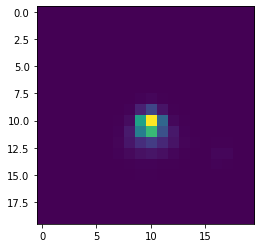

In [149]:
plt.imshow(tess_ffi[0])

In [150]:
df = Catalogs.query_object("EPIC"+str(epic), radius=0.0001, catalog="TIC").to_pandas()

In [156]:
df

,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec
0,4579916,348.407597,-11.74935,6.87541,-5.47881,8.2144,STAR,tmgaia2,20190415,NaN,...,NaN,1.251786,0.927743,348.407627,-11.749374,0.053077,0.031763,0,0,0.032403
